# QGAN

One of the main objectives of CERN Quantum Technology Initiative (CERN QTI) is to investigate if quantum computing can be used in the field of high-energy physics. In this project we will explore the idea behing Quantum Generative Adversarial Networks (QGANs) as a way to generate High Energy Physics (HEP) data. 

QGANs are fundamentally composed of two Quantum Neural Networks (QNNs) - a generator and a discriminator one - that compete between each other. The generative network generates candidates while the discriminative network evaluates them. The contest operates in terms of data distributions. Typically, the generative network learns to map from a latent space to a data distribution of interest, while the discriminative network distinguishes candidates produced by the generator from the true data distribution. The generative network's training objective is to increase the error rate of the discriminative network (i.e., "fool" the discriminator network by producing novel candidates that the discriminator thinks are not synthesized (are part of the true data distribution)).

This project will focus on the technical implementation details of a QGAN that can generate a 2-qubit state.

<div>
<img src="https://www.researchgate.net/profile/Shu-Hao-Wu/publication/326928193/figure/fig1/AS:657920580677642@1533871898291/The-quantum-generative-adversarial-network-QGAN-a-The-basic-components-of-QGAN.png" width="500"/>
</div>

In [1]:
import uproot
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.preprocessing import minmax_scale
from qutip import *

import numpy as np
import pandas as pd
import pennylane as qml
qml.drawer.use_style('black_white')
import tensorflow as tf
%matplotlib inline
np.set_printoptions(suppress=True)

## Prepare real data: Stop

In [2]:
path = "/Users/ketchum/Desktop/STOP_nTuples/"
tuples = "nTuples17_nanoAOD_v2021-10-15_test/"

signal = "T2DegStop_550_520_bdt"
treename="bdttree"

branches = ["LepPt","LepChg","LepEta","Met","Jet1Pt","mt","HT", "NbLoose","Njet", "JetHBpt", "DrJetHBLep",
              "JetHBDeepCSV","XS","Nevt","Event","weight"]

preSel = "(LepPt < 30) & (Met > 280) & (HT > 200) & (Jet1Pt > 110) & ((DPhiJet1Jet2 < 2.5) | (Jet2Pt < 60)) & (isTight == 1)\
         & (Met < 1000) & (mt < 300)"

In [3]:
# load root files
sgTree = uproot.open(path + tuples + signal +".root:"+treename)

# select important events
sgDict = sgTree.arrays(branches,preSel,library="np")

In [4]:
lumi = 414759
splitFactor = 2

sgLepPt  = sgDict["LepPt"]
sgLepChg = sgDict["LepChg"]
sgLepEta = sgDict["LepEta"]

sgMet = sgDict["Met"]
sgmt  = sgDict["mt"]
sgDR = sgDict["DrJetHBLep"]

sgW = sgDict["XS"]/sgDict["Nevt"]
wei = sgW*lumi*splitFactor

In [5]:
plotFeatures = False

if plotFeatures:
    plt.rcParams['figure.figsize'] = [15,10]
    fig, axs = plt.subplots(2, 3)
    ax1 = axs[0, 0]
    ax2 = axs[0, 1]
    ax3 = axs[0, 2]
    ax4 = axs[1, 0]
    ax5 = axs[1, 1]
    ax6 = axs[1, 2]
    
    label=["Signal"]
    
    binning=np.arange(0,30,1)
    ax1.hist(sgLepPt, weights = wei,color = "blue", alpha=0.25)
    ax1.legend(label, loc='best')
    ax1.set_xlim([0, 30])
    ax1.set_xlabel("$p_T(Lepton)$ [GeV]")

    binning=np.arange(-2,2,0.5)
    ax2.hist(sgLepChg, weights = wei,color = "blue", alpha=0.25)
    ax2.legend(label, loc='best')
    ax2.set_xlim([-1.5, 1.5])
    ax2.set_xlabel("Lepton Charge")

    minb=-3
    maxb=3
    nbins=20.
    step=(maxb-minb)/nbins
    binning=np.arange(minb,maxb,step)
    ax3.hist(sgLepEta, binning, weights = wei,color = "blue", alpha=0.25)
    ax3.legend(label, loc='best')
    ax3.set_xlim([-3, 3])
    ax3.set_xlabel("$\eta$ (Lepton)")

    minb=280
    maxb=1000
    nbins=36
    step=(maxb-minb)/nbins
    binning=np.arange(minb,maxb,step)
    ax4.hist(sgMet, binning, weights = wei,color = "blue", alpha=0.25)
    ax4.legend(label, loc='best')
    ax4.set_xlim([280, 1000])
    ax4.set_xlabel("$p_T^{miss}$ [GeV]")
    
    minb=0
    maxb=300
    nbins=20
    step=(maxb-minb)/nbins
    binning=np.arange(minb,maxb,step)
    ax5.hist(sgmt, binning, weights = wei,color = "blue", alpha=0.25)
    ax5.legend(label, loc='best')
    ax5.set_xlim([0, 300])
    ax5.set_xlabel("$M_T$ [GeV]")
    
    minb=0
    maxb=4
    nbins=20
    step=(maxb-minb)/nbins
    binning=np.arange(minb,maxb,step)
    ax6.hist(sgDR, binning, weights = wei,color = "blue", alpha=0.25)
    ax6.legend(label, loc='best')
    ax6.set_xlim([0, 4])
    ax6.set_xlabel("$\Delta R(J_{B1},lepton)$")

In [6]:
doDataFrame = False 

if doDataFrame:
    sgDF = pd.DataFrame(sgDict)
    display(sgDF)

In [7]:
lepChg_to_phi = minmax_scale(sgLepChg, feature_range=(0, np.pi))
lepPt_to_theta = minmax_scale(sgLepPt, feature_range=(0, np.pi))
lepEta_to_phi = minmax_scale(sgLepEta, feature_range=(0, 2*np.pi))
Met_to_theta = minmax_scale(sgMet, feature_range=(0, np.pi))

#lepPt_to_phi    = minmax_scale(sgLepPt, feature_range=(0, np.pi))
#lepChg_to_theta = minmax_scale(sgLepChg, feature_range=(0, np.pi))
#lepEta_to_omega = minmax_scale(sgLepEta, feature_range=(0, np.pi)) #2*np.pi))

#Met_to_phi  = minmax_scale(sgMet, feature_range=(0, np.pi))
#mt_to_theta = minmax_scale(sgmt, feature_range=(0, np.pi))
#DR_to_omega = minmax_scale(sgDR, feature_range=(0, np.pi))

In [8]:
plotAngleTransform = False

if plotAngleTransform:
    plt.rcParams['figure.figsize'] = [15,10]
    fig, axs = plt.subplots(2, 3)
    ax1 = axs[0, 0]
    ax2 = axs[0, 1]
    ax3 = axs[0, 2]
    ax4 = axs[1, 0]
    ax5 = axs[1, 1]
    ax6 = axs[1, 2]
    
    label=["Signal Transformed"]
   
    ax1.hist(lepPt_to_phi, weights = wei,color = "blue", alpha=0.25)
    ax1.legend(label, loc='best')
    ax1.set_xlim([0, np.pi])
    ax1.set_xlabel("$p_T(Lepton)$ [$\phi$ rad]")
    
    ax2.hist(lepChg_to_theta, weights = wei,color = "blue", alpha=0.25)
    ax2.legend(label, loc='best')
    ax2.set_xlim([0, np.pi])
    ax2.set_xlabel("Lepton Charge [$\Theta$ rad]")

    minb=0
    maxb=n2*np.pi#np.pi
    nbins=20.
    step=(maxb-minb)/nbins
    binning=np.arange(minb,maxb,step)
    ax3.hist(lepEta_to_omega, binning, weights = wei,color = "blue", alpha=0.25)
    ax3.legend(label, loc='best')
    ax3.set_xlim([0, np.pi]) #2*np.pi])
    ax3.set_xlabel("$\eta$ (Lepton) [$\omega$ rad]")      
    
    minb=0
    maxb=np.pi
    nbins=36
    step=(maxb-minb)/nbins
    binning=np.arange(minb,maxb,step)
    ax4.hist(Met_to_phi, binning, weights = wei,color = "blue", alpha=0.25)
    ax4.legend(label, loc='best')
    ax4.set_xlim([0, np.pi])
    ax4.set_xlabel("$p_T^{miss}$ [$\phi$ rad]")
    
    minb=0
    maxb=np.pi
    nbins=20
    step=(maxb-minb)/nbins
    binning=np.arange(minb,maxb,step)
    ax5.hist(mt_to_theta, binning, weights = wei,color = "blue", alpha=0.25)
    ax5.legend(label, loc='best')
    ax4.set_xlim([0, np.pi])
    ax5.set_xlabel("$M_T$ [$\Theta$ rad]")
    
    minb=0
    maxb=np.pi
    nbins=20
    step=(maxb-minb)/nbins
    binning=np.arange(minb,maxb,step)
    ax6.hist(DR_to_omega, binning, weights = wei,color = "blue", alpha=0.25)
    ax6.legend(label, loc='best')
    ax4.set_xlim([0, np.pi])
    ax6.set_xlabel("$\Delta R(J_{B1},lepton)$ [$\omega$ rad]")

In [9]:
def spherical_to_cartesian(theta,phi):
    x = np.sin(theta)*np.cos(phi)
    y = np.sin(theta)*np.sin(phi)
    z = np.cos(theta)
    return x,y,z

def cartesian_to_spherical(x,y,z):
    if x > 0:
        phi = np.arctan(y/x)
    elif x < 0 and y >= 0:
        phi = np.arctan(y/x) - np.pi
    elif x < 0 and y < 0:
        phi = np.arctan(y/x) + np.pi
    elif x == 0 and y > 0:
        phi = np.pi/2
    elif x == 0 and y < 0:
        phi = -np.pi/2
    elif x == 0 and y == 0:
        phi = 0 # Undefined

    theta = np.arccos(z)
    return theta, phi

In [10]:
tlist = np.linspace(0, 1, 40)
#nrm = mpl.colors.Normalize()
#colors = cm.cool(nrm(tlist))
colors = cm.cool(tlist)

In [11]:
generateAssets = False

if generateAssets:
    bloch1 = Bloch()
    bloch2 = Bloch()
    c = 0
    for i in range(0,3400,85):
        x1,y1,z1=spherical_to_cartesian(lepPt_to_theta[i],lepChg_to_phi[i])
        x2,y2,z2=spherical_to_cartesian(Met_to_theta[i],lepEta_to_phi[i])
        vec1=[x1,y1,z1]
        vec2=[x2,y2,z2]
        #vec1=[lepPt_to_phi[i],lepChg_to_theta[i],lepEta_to_omega[i]]
        #vec2=[Met_to_phi[i],mt_to_theta[i],DR_to_omega[i]]

        bloch_ev_1 = Bloch()
        bloch_ev_2 = Bloch()
        bloch1.add_vectors(vec1)
        bloch2.add_vectors(vec2)
        bloch_ev_1.add_vectors(vec1)
        bloch_ev_2.add_vectors(vec2)
        bloch_ev_1.vector_color = list(colors[c:])
        bloch_ev_2.vector_color = list(colors[c:])
        bloch_ev_1.save("assets/bloch_event"+str(i)+"_1.png")
        bloch_ev_2.save("assets/bloch_event"+str(i)+"_2.png")
        c+=1

    bloch1.vector_color = list(colors)
    bloch2.vector_color = list(colors)    

    bloch1.save("assets/bloch1.png")
    bloch2.save("assets/bloch2.png")

| Event 680 Bloch 1: Lepton Charge and pT  | Event 680 Bloch 2: Lepton Eta and Met |
|-|-|
|<div> <img src="assets/bloch_event680_1.png" width="250"/></div>|<div><img src="assets/bloch_event680_2.png" width="250"/></div>|

| Bloch 1: Lepton Charge and pT  | Bloch 2: Lepton Eta and Met |
|-|-|
|<div> <img src="assets/bloch1.png" width="250"/></div>|<div><img src="assets/bloch2.png" width="250"/></div>|



In [12]:
ev_idx = 680

In [13]:
angles=[lepPt_to_theta[ev_idx],lepChg_to_phi[ev_idx],Met_to_theta[ev_idx],lepEta_to_phi[ev_idx]]

x1,y1,z1=spherical_to_cartesian(lepPt_to_theta[ev_idx],lepChg_to_phi[ev_idx])
x2,y2,z2=spherical_to_cartesian(Met_to_theta[ev_idx],lepEta_to_phi[ev_idx])

In [14]:
print(angles)

[0.6196836, 3.1415927, 1.8112353, 4.293872]


## Quantum

Using a **5-qubit** simulator device running in Cirq:
- Qubit **0 & 1**: the 2 qubit state that we are trying to generate
- Qubit **2 & 3**: the generator's playground
- Qubit **4**: the generator's guess


In [15]:
dev = qml.device('cirq.simulator', wires=5)
#dev = qml.device('qiskit.aer', wires=5)

In [16]:
def real(angles, **kwargs):
    #qml.Hadamard(wires=0)
    qml.RY(angles[0], wires=0)
    qml.RZ(angles[1], wires=0)
    qml.RY(angles[2], wires=1)
    qml.RZ(angles[3], wires=1)
    #qml.CNOT(wires=[0,1])      # should 2 qubits be entangled?

def real_rand(angles, **kwargs):
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0,1])
    qml.RX(angles[0], wires=0)
    qml.RY(angles[1], wires=0)
    qml.RZ(angles[2], wires=0)
    qml.RX(angles[3], wires=0)
    qml.RY(angles[4], wires=0)
    qml.RZ(angles[5], wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RX(angles[3], wires=1)
    qml.RY(angles[4], wires=1)
    qml.RZ(angles[5], wires=1)
    qml.RX(angles[0], wires=1)
    qml.RY(angles[1], wires=1)
    qml.RZ(angles[2], wires=1)

## Discriminator

<div> <img src="assets/discriminator.png" width="750"/></div>

In [17]:
# The discriminator acts on wires 0, 1, and 4
# We need 27 weights: 8 x 3 generator layers + 3 for final descrimination layer

def discriminator(w, **kwargs):
    qml.Barrier(wires=[0,4],only_visual=True)
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    qml.CNOT(wires=[0,1])
    qml.Barrier(wires=[0,4],only_visual=True)
    discriminator_layer(w[:8])
    discriminator_layer(w[8:16]) 
    discriminator_layer(w[16:24])
    qml.RX(w[24], wires=4)
    qml.RY(w[25], wires=4)
    qml.RZ(w[26], wires=4)
    
def discriminator_layer(w, **kwargs):
    qml.RX(w[0], wires=0)
    qml.RX(w[1], wires=1)
    qml.RX(w[2], wires=4)
    qml.RZ(w[3], wires=0)
    qml.RZ(w[4], wires=1)
    qml.RZ(w[5], wires=4)
    qml.MultiRZ(w[6], wires=[0, 1])
    qml.MultiRZ(w[7], wires=[1, 4])
    # 8 weights

## Generator

<div> <img src="assets/generator.png"/></div>

In [18]:
# Define the generator
# Wires 0 and 1 are the 2 qubit state.
# We need 45 weights: 11 x 3 generator layers + 11 for final generation layer

def generator(w, **kwargs):
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    qml.CNOT(wires=[0,1])
    qml.Barrier(wires=[0,4],only_visual=True)
    generator_layer(w[:11])
    generator_layer(w[11:22])
    generator_layer(w[22:33])
    qml.RX(w[33], wires=0)
    qml.RY(w[34], wires=0)
    qml.RZ(w[35], wires=0)
    qml.RX(w[36], wires=1)
    qml.RY(w[37], wires=1)
    qml.RZ(w[38], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RX(w[39], wires=0)
    qml.RY(w[40], wires=0)
    qml.RZ(w[41], wires=0)
    qml.RX(w[42], wires=1)
    qml.RY(w[43], wires=1)
    qml.RZ(w[44], wires=1)

def generator_layer(w):
    qml.RY(w[0], wires=0)
    qml.RY(w[1], wires=1)
    qml.RY(w[2], wires=2)
    qml.RY(w[3], wires=3)
    qml.RZ(w[4], wires=0)
    qml.RZ(w[5], wires=1)
    qml.RZ(w[6], wires=2)
    qml.RZ(w[7], wires=3)
    qml.MultiRZ(w[8], wires=[0, 1])
    qml.MultiRZ(w[9], wires=[2, 3])
    qml.MultiRZ(w[10], wires=[1, 2])
    # 11 weights

In [19]:
@qml.qnode(dev, interface='tf')
def real_disc_circuit(angles, disc_weights):
    real(angles)
    discriminator(disc_weights)
    return qml.expval(qml.PauliZ(4))

@qml.qnode(dev, interface='tf')
def gen_disc_circuit(gen_weights, disc_weights):
    generator(gen_weights)
    discriminator(disc_weights)
    return qml.expval(qml.PauliZ(4))    

In [20]:
def prob_real_true(disc_weights):
    true_disc_output = real_disc_circuit(angles, disc_weights)
    # convert to probability
    prob_real_true = (true_disc_output + 1) / 2.
    return prob_real_true


def prob_fake_true(gen_weights, disc_weights):
    fake_disc_output = gen_disc_circuit(gen_weights, disc_weights)
    # convert to probability
    prob_fake_true = (fake_disc_output + 1) / 2.
    return prob_fake_true


def disc_cost(disc_weights):
    cost = prob_fake_true(gen_weights, disc_weights) - prob_real_true(disc_weights)
    return cost


def gen_cost(gen_weights):
    return -prob_fake_true(gen_weights, disc_weights)

In [21]:
np.random.seed(42)
eps = 1e-2
init_gen_weights = np.array([np.pi] + [0] * 44) + \
                   np.random.normal(scale=eps, size=(45,))
init_disc_weights = np.random.normal(size=(27,))

gen_weights = tf.Variable(init_gen_weights)
disc_weights = tf.Variable(init_disc_weights)

Discriminator

(<Figure size 1728x288 with 1 Axes>, <Axes:>)


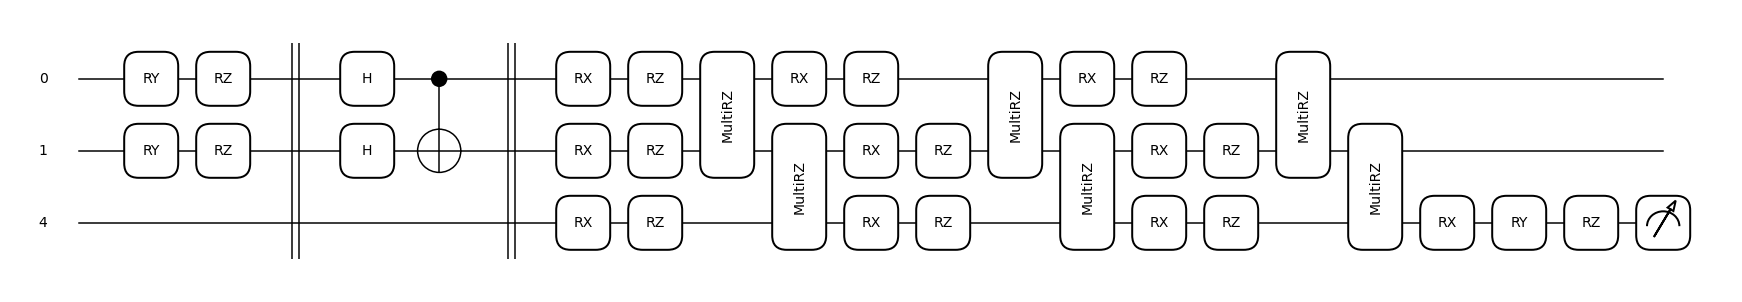

In [22]:
print("Discriminator\n")
print(qml.draw_mpl(real_disc_circuit)(angles,disc_weights))

Generator

(<Figure size 3168x432 with 1 Axes>, <Axes:>)


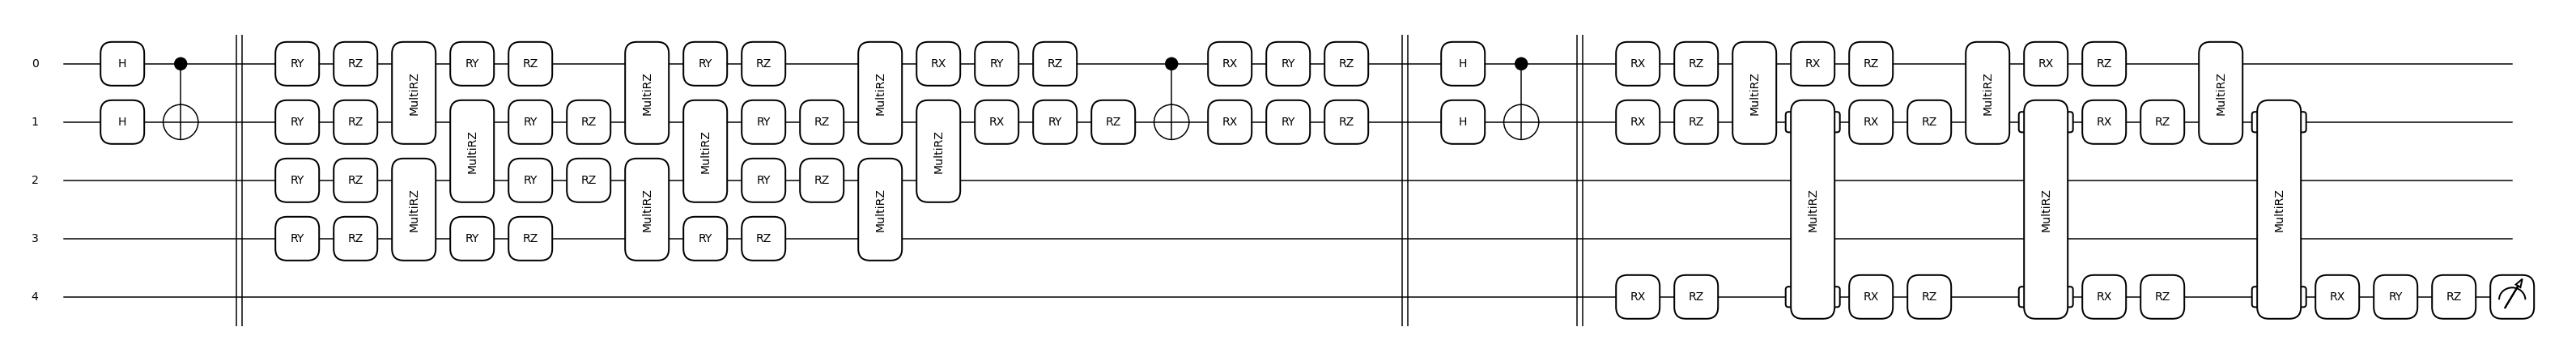

In [23]:
print("Generator\n")
print(qml.draw_mpl(gen_disc_circuit)(gen_weights, disc_weights))

In [24]:
print("Probability classify real as real: {:.3f} %".format(prob_real_true(disc_weights).numpy()*100))
print("Probability classify fake as real: {:.3f} %".format(prob_fake_true(gen_weights, disc_weights).numpy()*100))

Probability classify real as real: 90.137 %
Probability classify fake as real: 58.832 %


In [25]:
opt = tf.keras.optimizers.SGD(0.4)
disc_loss = []
gen_loss = []

In [26]:
def train_disc(it,disc_loss):
    print("== Training discriminator")
    cost = lambda: disc_cost(disc_weights)

    for step in range(it+1):
        opt.minimize(cost, disc_weights)
        cost_val = cost().numpy()
        disc_loss += [cost_val]
        #if step % int((it/5)) == 0:    
        if step % 5 == 0:    
            print("Step {}: cost = {:.6f}".format(step, cost_val))
            print(" Prob. real as real: {:.3f} %".format(prob_real_true(disc_weights).numpy()*100))
            print(" Prob. fake as real: {:.3f} %".format(prob_fake_true(gen_weights, disc_weights).numpy()*100))

In [27]:
def train_gen(it,gen_loss):
    print("== Training generator")
    cost = lambda: gen_cost(gen_weights)

    for step in range(it+1):
        opt.minimize(cost, gen_weights)
        cost_val = cost().numpy()
        gen_loss += [cost_val]
        #if step % int((it/5)) == 0:    
        if step % 5 == 0:
            print("Step {}: Prob. fake as real = {:.3f} %".format(step, abs(cost_val*100)))

In [28]:
print("Cycle 1")
train_disc(20,disc_loss)
train_gen(5,gen_loss)
print("\nCycle 2")
train_disc(20,disc_loss)
train_gen(5,gen_loss)
print("\nCycle 3")
train_disc(20,disc_loss)
train_gen(5,gen_loss)

Cycle 1
== Training discriminator
Step 0: cost = -0.457116
 Prob. real as real: 84.418 %
 Prob. fake as real: 38.706 %
Step 5: cost = -0.658244
 Prob. real as real: 74.257 %
 Prob. fake as real: 8.433 %
Step 10: cost = -0.670991
 Prob. real as real: 73.940 %
 Prob. fake as real: 6.841 %
Step 15: cost = -0.678560
 Prob. real as real: 74.284 %
 Prob. fake as real: 6.428 %
Step 20: cost = -0.688501
 Prob. real as real: 75.199 %
 Prob. fake as real: 6.349 %
== Training generator
Step 0: Prob. fake as real = 16.851 %
Step 5: Prob. fake as real = 99.931 %

Cycle 2
== Training discriminator
Step 0: cost = 0.210678
 Prob. real as real: 78.479 %
 Prob. fake as real: 99.547 %
Step 5: cost = -0.172617
 Prob. real as real: 86.291 %
 Prob. fake as real: 69.029 %
Step 10: cost = -0.579404
 Prob. real as real: 84.928 %
 Prob. fake as real: 26.988 %
Step 15: cost = -0.649715
 Prob. real as real: 85.200 %
 Prob. fake as real: 20.228 %
Step 20: cost = -0.661562
 Prob. real as real: 84.753 %
 Prob. fake 

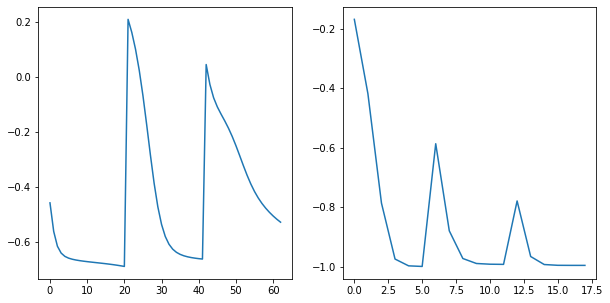

In [29]:
plt.rcParams['figure.figsize'] = [10,5]

fig, axs = plt.subplots(1, 2)
ax1 = axs[0]
ax2 = axs[1]

ax1.plot(disc_loss)
ax2.plot(gen_loss)

In [30]:
obs = [qml.PauliX(0), qml.PauliY(0), qml.PauliZ(0),qml.PauliX(1), qml.PauliY(1), qml.PauliZ(1)]

bloch_vector_real = qml.map(real, obs, dev, interface="tf")
bloch_vector_fake = qml.map(generator, obs, dev, interface="tf")

bv_real = bloch_vector_real(angles).numpy()
bv_fake = bloch_vector_fake(gen_weights).numpy()
difference = np.absolute(bv_real - bv_fake)

x1,y1,z1,x2,y2,z2=bv_real
X1,Y1,Z1,X2,Y2,Z2=bv_fake
d1,d2,d3,d4,d5,d6=difference

print("Real Bloch vector:      Q1=[{0:.3f}, {1:.3f}, {2:.3f}] \t Q2=[{3:.3f}, {4:.3f}, {5:.3f}]".format(x1,y1,z1,x2,y2,z2))
print("Generator Bloch vector: Q1=[{0:.3f}, {1:.3f}, {2:.3f}] \t Q2=[{3:.3f}, {4:.3f}, {5:.3f}]".format(X1,Y1,Z1,X2,Y2,Z2))
print("Difference:             Q1=[{0:.3f}, {1:.3f}, {2:.3f}] \t Q2=[{3:.3f}, {4:.3f}, {5:.3f}]".format(d1,d2,d3,d4,d5,d6))

accuracy = difference / (np.pi)
average_accuracy = 0
for i in range(len(accuracy)):
    average_accuracy += accuracy[i]
average_accuracy = average_accuracy / len(accuracy)
average_accuracy = 1 - average_accuracy
print("Accuracy: {0:.3f} %".format(average_accuracy*100))

Real Bloch vector:      Q1=[-0.581, -0.000, 0.814] 	 Q2=[-0.395, -0.887, -0.238]
Generator Bloch vector: Q1=[-0.637, -0.179, 0.399] 	 Q2=[-0.222, -0.583, -0.457]
Difference:             Q1=[0.056, 0.179, 0.415] 	 Q2=[0.173, 0.305, 0.219]
Accuracy: 92.856 %


In [31]:
def invert_minmax(X_scaled,min,max,feature):
    X_std = (X_scaled - min) / (max-min)
    X=X_std*(feature.max()-feature.min())+feature.min()
    return X

def theta_to_lepPt(theta):
    return invert_minmax(theta,0,np.pi,sgLepPt)

def phi_to_lepChg(phi):
    return np.sign(invert_minmax(phi,0,np.pi,sgLepChg))

def theta_to_Met(theta):
    return invert_minmax(theta,0,np.pi,sgMet)

def phi_to_lepEta(phi):
    return invert_minmax(phi,0,2*np.pi,sgLepEta)

In [32]:
def infoQu(name,angles,bv_real,bv_fake):
    theta,phi = angles
    x,y,z=spherical_to_cartesian(theta,phi)
    X,Y,Z = bv_real
    THETA,PHI=cartesian_to_spherical(X,Y,Z)
    Xf,Yf,Zf = bv_fake
    THETAf,PHIf=cartesian_to_spherical(Xf,Yf,Zf)
    
    bloch = Bloch()
    
    vec_og=[x,y,z]
    vec_real=[X,Y,Z]
    vec_fake=[Xf,Yf,Zf]

    bloch.add_vectors(vec_og)
    bloch.add_vectors(vec_real)
    bloch.add_vectors(vec_fake)
    bloch.vector_color = list(colors[0:40:19])

    print("==   "+ name +"   ==")
    print("og   | theta,phi:  {0:.3f}  {1:.3f}".format(theta,phi))
    print("real | THETA,PHI:  {0:.3f}  {1:.3f}".format(THETA,PHI))
    print("fake | THETA,PHI:  {0:.3f}  {1:.3f}".format(THETAf,PHIf))
    print("      ----------------------------")
    print("og   | x,y,z: {0:.3f} {1:.3f} {2:.3f}".format(x,y,z))
    print("real | X,Y,Z: {0:.3f} {1:.3f} {2:.3f}".format(X,Y,Z))
    print("fake | X,Y,Z: {0:.3f} {1:.3f} {2:.3f}".format(Xf,Yf,Zf))
    
    bloch.show()

    return THETA, PHI, THETAf, PHIf

==   Q1   ==
og   | theta,phi:  0.620  3.142
real | THETA,PHI:  0.620  3.142
fake | THETA,PHI:  1.160  3.416
      ----------------------------
og   | x,y,z: -0.581 -0.000 0.814
real | X,Y,Z: -0.581 -0.000 0.814
fake | X,Y,Z: -0.637 -0.179 0.399


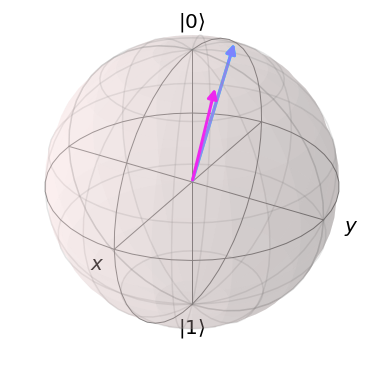

==   Q2   ==
og   | theta,phi:  1.811  4.294
real | THETA,PHI:  1.811  4.294
fake | THETA,PHI:  2.045  4.349
      ----------------------------
og   | x,y,z: -0.395 -0.887 -0.238
real | X,Y,Z: -0.395 -0.887 -0.238
fake | X,Y,Z: -0.222 -0.583 -0.457


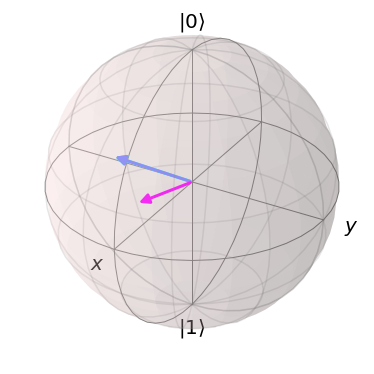

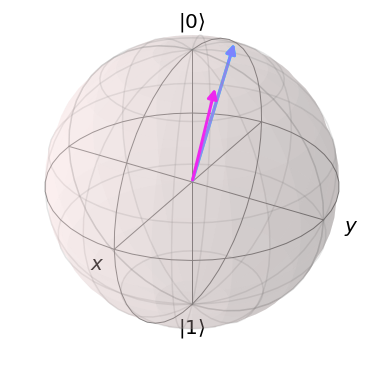

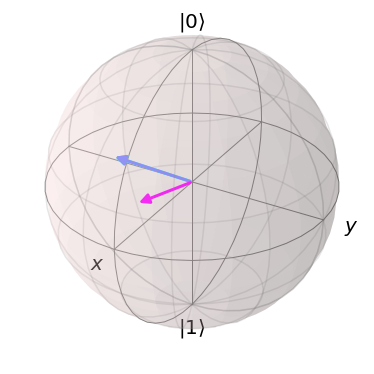

In [33]:
THETA1, PHI1, THETAf1, PHIf1 = infoQu("Q1",angles[:2],bv_real[:3],bv_fake[:3])
THETA2, PHI2, THETAf2, PHIf2 = infoQu("Q2",angles[2:],bv_real[3:],bv_fake[3:])

In [34]:
printCircuits = False

if printCircuits:
    print("Final Discriminator\n")
    print(qml.draw(real_disc_circuit, max_length=60)(angles,disc_weights))
    print("Final Generator\n")
    print(qml.draw(gen_disc_circuit, max_length=60)(gen_weights,disc_weights))

In [35]:
print("\n\n     |\tLepPt | LepChg | MET | LepEta")
print("-------------------------------------")
print("real |\t  {0:.1f} |    {1:.0f}   | {2:.0f} | {3:.2f}".format(theta_to_lepPt(THETA1),phi_to_lepChg(PHI1),theta_to_Met(THETA2),phi_to_lepEta(PHI2)))
print("fake |\t {0:.1f} |    {1:.0f}   | {2:.0f} | {3:.2f}".format(theta_to_lepPt(THETAf1),phi_to_lepChg(PHIf1),theta_to_Met(THETAf2),phi_to_lepEta(PHIf2)))
print("\t ")



     |	LepPt | LepChg | MET | LepEta
-------------------------------------
real |	  8.7 |    1   | 695 | 0.90
fake |	 13.3 |    1   | 748 | 0.95
	 


Inspiration:
- https://arxiv.org/pdf/1804.08641.pdf
- https://pennylane.ai/qml/demos/tutorial_QGAN.html
- https://nbviewer.org/github/laurgao/qgan/blob/main/QGAN2.ipynb

More inpiration:
- https://www.nature.com/articles/ncomms5213.pdf
- https://arxiv.org/pdf/1704.05018.pdf
- https://arxiv.org/pdf/1801.01053.pdf
- https://arxiv.org/pdf/1804.00633.pdf
- https://arxiv.org/pdf/1803.11537.pdf